In [1]:
import json
import gzip
import numpy as np
import pandas as pd
import pickle

from bias import Bias, SimplifiedBias
from pprint import pprint

%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
entities_json_file_name = '../data/entities.json.pickle'

def read_entities(entities_json_file_name):
    def read_file(postfix):
        with gzip.open(entities_json_file_name + postfix, 'rb') as infile:
            return pickle.load(infile)
    return read_file('.gz.0') + read_file('.gz.1')

In [3]:
data = read_entities(entities_json_file_name)

In [4]:
df = pd.read_csv('../data/newsclust.csv')

In [5]:
df = df.query("site != 'cbn.com'")

In [6]:
bias_type = 'bias'

df['bias'] = df.apply(lambda row: Bias.get_bias_for_domain(row['site']), axis=1)

In [7]:
doc = []
bias = []
dom = []
for idx, row in data:
    js = json.loads(row)
    e = {}
    b = df.ix[idx, 'bias']
    d = df.ix[idx, 'site']
    for entity in js['entities']:
        try:
            typ = entity['type']
            name = entity['name'].lower()
            salience = entity['salience']
            score = entity['sentiment']['score']
            magnitude = entity['sentiment']['magnitude']
            e[name] = score
        except KeyError:
            e[name] = 0
    doc.append(e)
    bias.append(b)
    dom.append(d)

In [15]:
k = 19

In [16]:
print(bias[k])
print(dom[k])
print(doc[k])

Bias.RIGHT_CENTER
azcentral.com
{'bill belichick': 0, 'the new england patriots': -0.10000000149011612, 'nfl': 0, 'tom brady': 0, 'football': 0, 'seattle': 0, 'allegation': -0.30000001192092896, 'seattle seahawks': 0, 'silver': 0, 'drama': -0.4000000059604645, '18th super bowl': 0, 'quarterback': 0, 'commentary': 0.20000000298023224, 'baltimore ravens': 0, 'coaches': 0, 'coach': 0, 'league': -0.10000000149011612, 'fullscreen': 0, 'indianapolis colts': -0.20000000298023224, 'russell wilson': 0, 'aaron rodgers': 0, 'coincidence': 0, 'accident': -0.10000000149011612, 'kyle terada-usa today sports) fullscreen': 0, 'game': 0, 'footing': 0, 'footballs': -0.8999999761581421, 'sports': 0, 'new england': 0, 'thing': 0, 'report': 0, 'quarterbacks': 0, 'season': 0, 'jamming signals': 0, 'franchise': 0, 'question': 0, 'super bowl xlix': 0, 'first-round draft pick': 0, 'advantage': 0, 'loophole': -0.30000001192092896, 'afc championship game': 0, 'stage': 0, 'game balls': 0, 'punishment': -0.3000000

In [13]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [10]:
TEST_DOMAINS =  {
    'bloomberg.com',
     'breitbart.com',
     'bbc.com',
     'ijr.com',
     'wsj.com',
     'nypost.com',
     'talkingpointsmemo.com',
     'motherhones.com',
     'usatoday.com',
     'afp.com',
     'rightwingnews.com',
     'occupydemocrats.com'
}

In [11]:
X_train = [doc[i] for i in range(len(doc)) if dom[i] not in TEST_DOMAINS]
y_train = [bias[i].value for i in range(len(doc)) if dom[i] not in TEST_DOMAINS]

X_test = [doc[i] for i in range(len(doc)) if dom[i] in TEST_DOMAINS]
y_test = [bias[i].value for i in range(len(doc)) if dom[i] in TEST_DOMAINS]
dom_test = [dom[i] for i in range(len(doc)) if dom[i] in TEST_DOMAINS]

In [14]:
pipeline = Pipeline([
    ('vect', DictVectorizer()),
#     ('svd', TruncatedSVD(n_components=20)),
    ('clf', LogisticRegression())
])

NameError: name 'DictVectorizer' is not defined

In [231]:
%time pipeline.fit(X_train, y_train)

CPU times: user 2.74 s, sys: 53.3 ms, total: 2.8 s
Wall time: 2.83 s


Pipeline(memory=None,
     steps=[('vect', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [232]:
print(classification_report(y_test, pipeline.predict(X_test)))

             precision    recall  f1-score   support

          0       0.15      0.00      0.00      2019
          1       0.07      0.12      0.09      1497
          2       0.16      0.66      0.26      2584
          3       0.33      0.02      0.04      3498
          4       0.00      0.00      0.00      3004
          5       0.21      0.29      0.25      3208
          6       0.21      0.01      0.02      1836

avg / total       0.17      0.16      0.10     17646



In [233]:
from sklearn.model_selection import GridSearchCV

In [234]:
param_grid = {
#     'vect__ngram_range': ((1, 1), (1, 2)),
#     'vect__max_df': (0.5, 0.75),
#     'svd__n_components': [10, 20, 100],
    'clf__C': [.1, 1, 10, 100, 1000]
}

In [235]:
%%time
grid = GridSearchCV(pipeline, cv=3, n_jobs=6, param_grid=param_grid, verbose=10)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__C=0.1 ......................................................
[CV] clf__C=0.1 ......................................................
[CV] clf__C=0.1 ......................................................
[CV] clf__C=1 ........................................................
[CV] clf__C=1 ........................................................
[CV] clf__C=1 ........................................................
[CV] ....................... clf__C=0.1, score=0.291028, total=   2.0s


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    3.5s


[CV] ....................... clf__C=0.1, score=0.293211, total=   2.1s
[CV] clf__C=10 .......................................................
[CV] ....................... clf__C=0.1, score=0.292777, total=   2.3s
[CV] clf__C=10 .......................................................
[CV] clf__C=10 .......................................................
[CV] ......................... clf__C=1, score=0.321920, total=   3.3s
[CV] ......................... clf__C=1, score=0.328656, total=   3.2s
[CV] clf__C=100 ......................................................
[CV] clf__C=100 ......................................................
[CV] ......................... clf__C=1, score=0.334578, total=   3.3s


[Parallel(n_jobs=6)]: Done   6 out of  15 | elapsed:    7.2s remaining:   10.8s


[CV] clf__C=100 ......................................................
[CV] ........................ clf__C=10, score=0.328957, total=   6.1s
[CV] ........................ clf__C=10, score=0.334621, total=   5.9s
[CV] clf__C=1000 .....................................................


[Parallel(n_jobs=6)]: Done   8 out of  15 | elapsed:   11.6s remaining:   10.2s


[CV] clf__C=1000 .....................................................
[CV] ........................ clf__C=10, score=0.337024, total=   6.3s
[CV] clf__C=1000 .....................................................
[CV] ....................... clf__C=100, score=0.331145, total=  21.5s


[Parallel(n_jobs=6)]: Done  10 out of  15 | elapsed:   29.6s remaining:   14.8s


[CV] ....................... clf__C=100, score=0.327369, total=  22.5s
[CV] ....................... clf__C=100, score=0.334235, total=  22.5s


[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:   31.0s remaining:    7.7s


[CV] ...................... clf__C=1000, score=0.308828, total=  29.4s
[CV] ...................... clf__C=1000, score=0.320934, total=  33.1s
[CV] ...................... clf__C=1000, score=0.308230, total=  34.0s


[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:   46.6s finished


CPU times: user 10 s, sys: 868 ms, total: 10.9 s
Wall time: 53.5 s


In [236]:
best_clf = grid.best_estimator_
print(classification_report(y_test, best_clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.39      0.01      0.02      2019
          1       0.08      0.14      0.10      1497
          2       0.16      0.60      0.25      2584
          3       0.35      0.04      0.07      3498
          4       0.21      0.01      0.01      3004
          5       0.22      0.30      0.25      3208
          6       0.19      0.03      0.05      1836

avg / total       0.24      0.17      0.11     17646



In [237]:
params = grid.cv_results_['params']
train_scores = np.mean([grid.cv_results_[("split%s_train_score" % d)] for d in range(3)], axis=0)
test_scores = np.mean([grid.cv_results_[("split%s_test_score" % d)] for d in range(3)], axis=0)

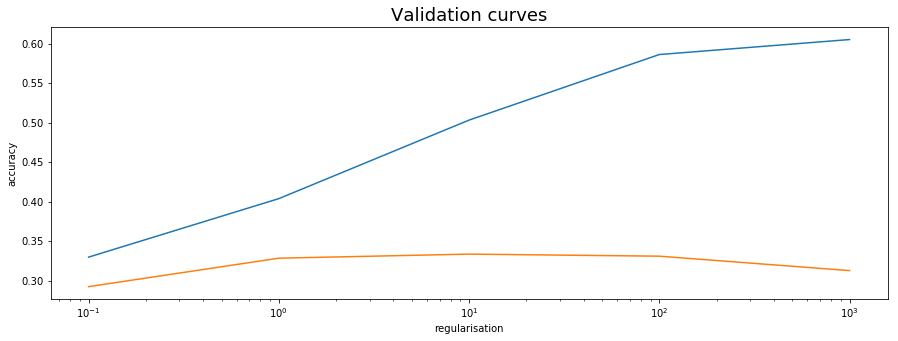

In [238]:
plt.figure(figsize=(15, 5))
plt.semilogx(param_grid['clf__C'], train_scores)
plt.semilogx(param_grid['clf__C'], test_scores)
plt.title("Validation curves", size=18)
plt.xlabel("regularisation")
plt.ylabel("accuracy")
plt.show()

In [239]:
df_test = pd.DataFrame({'bias':y_test, 'site':dom_test})

In [240]:
df_test.head()

,bias,site
0,2,bbc.com
1,2,bbc.com
2,4,wsj.com
3,4,wsj.com
4,4,wsj.com


In [241]:
if bias_type == 'bias':
    bias = [Bias(v) for v in best_clf.predict(X_test)]
    cols = ['Bias.EXTREME_LEFT', 'Bias.LEFT', 'Bias.LEFT_CENTER', 'Bias.LEAST_BIASED', 'Bias.RIGHT_CENTER', 'Bias.RIGHT', 'Bias.EXTREME_RIGHT']
    ticks = ['EXT_LEFT', 'LEFT', 'LEFT_CENTER', 'UNBIASED', 'RIGHT_CENTER', 'RIGHT', 'EXTREME_RIGHT']
    k = 7
elif bias_type == 'simplified_bias':
    bias = [SimplifiedBias(v) for v in best_clf.predict(X_test)]
    cols = ['SimplifiedBias.LEFT', 'SimplifiedBias.UNBIASED', 'SimplifiedBias.RIGHT']
    ticks = ['LEFT', 'UNBIASED', 'RIGHT']
    k = 3
else:
    raise ValueError

df_test = df_test.assign(pred=pd.Series(bias).values)

In [242]:
dfc = df_test.copy()
dfc['bias'] = dfc['bias'].astype(str)
dfc['pred'] = dfc['pred'].astype(str)
r = dfc.groupby(['site', 'pred']).apply(lambda g: len(g)).unstack().fillna(0)[cols]

r = (r - r.mean(axis=0)) / np.sqrt(r.var(axis=0)) + (0 - ((r - r.mean(axis=0)) / np.sqrt(r.var(axis=0))).min())
r = r / np.repeat(r.sum(axis=1).values[:, None], k, axis=1)
r

pred,Bias.EXTREME_LEFT,Bias.LEFT,Bias.LEFT_CENTER,Bias.LEAST_BIASED,Bias.RIGHT_CENTER,Bias.RIGHT,Bias.EXTREME_RIGHT
site,,,,,,,
afp.com,0.046129,0.264798,0.151654,0.348339,0.027064,0.085681,0.076336
bbc.com,0.069751,0.050844,0.259151,0.286913,0.061384,0.093569,0.178387
bloomberg.com,0.000000,0.036374,0.085380,0.423537,0.256166,0.119719,0.078823
breitbart.com,0.101285,0.118657,0.036311,0.124366,0.138655,0.186138,0.294588
ijr.com,0.089615,0.085738,0.246979,0.019256,0.052577,0.249681,0.256153
nypost.com,0.000000,0.042212,0.343696,0.027998,0.222960,0.134451,0.228684
occupydemocrats.com,0.276136,0.263291,0.000000,0.025430,0.000000,0.253398,0.181746
rightwingnews.com,0.175747,0.075239,0.143672,0.021580,0.034370,0.255622,0.293771
talkingpointsmemo.com,0.130172,0.144591,0.302274,0.000000,0.101829,0.255857,0.065277


In [243]:
def viz(domain):
    plt.figure(figsize=(15, 2))
    plt.stem(r.ix[domain, :])
    plt.xticks(range(k), ticks, rotation=45)
    plt.title(domain, size=18)
    plt.show()

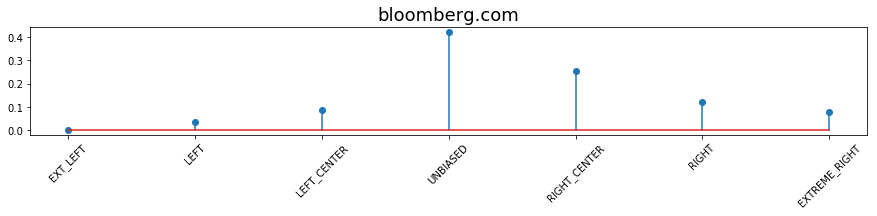

In [244]:
viz('bloomberg.com')

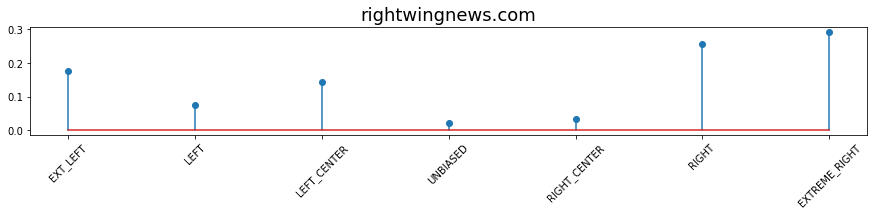

In [245]:
viz('rightwingnews.com')

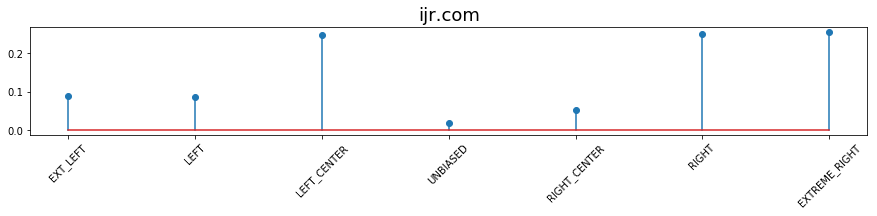

In [246]:
viz('ijr.com')

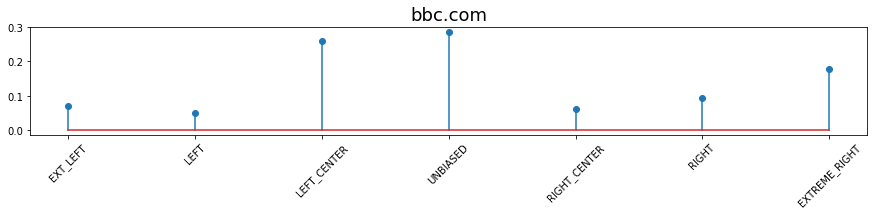

In [247]:
viz('bbc.com')

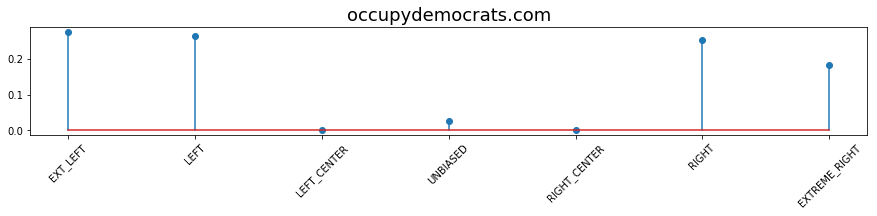

In [248]:
viz('occupydemocrats.com')

In [181]:
json.loads(data[0][1])

{'entities': [{'mentions': [{'sentiment': {},
     'text': {'beginOffset': 636, 'content': 'social media users'},
     'type': 'COMMON'}],
   'name': 'social media users',
   'salience': 0.05783792585134506,
   'sentiment': {'magnitude': 0.699999988079071,
    'score': -0.10000000149011612},
   'type': 'PERSON'},
  {'mentions': [{'sentiment': {},
     'text': {'beginOffset': 27, 'content': 'social media'},
     'type': 'COMMON'}],
   'name': 'social media',
   'salience': 0.05403602868318558,
   'sentiment': {},
   'type': 'OTHER'},
  {'mentions': [{'sentiment': {'magnitude': 0.4000000059604645,
      'score': -0.4000000059604645},
     'text': {'beginOffset': 99, 'content': 'thing'},
     'type': 'COMMON'}],
   'name': 'thing',
   'salience': 0.05193149298429489,
   'sentiment': {'magnitude': 0.4000000059604645,
    'score': -0.4000000059604645},
   'type': 'OTHER'},
  {'mentions': [{'sentiment': {'magnitude': 0.10000000149011612,
      'score': -0.10000000149011612},
     'text': {'b

In [194]:
doc

[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
